In [1]:
!pip install awswrangler
!pip install wntr

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


In [2]:

import wntr 
import matplotlib.pyplot as plt
from itertools import combinations 

In [3]:
import numpy as np
import pandas as pd
import random

In [4]:
leak_start_time = 0.5*3600
leak_end_time = 3600
leak_area = round(3.14*0.03*0.03*0.25,5)
# oc = [600,1200,1800,2400,3000,3600]

In [5]:
wn = wntr.network.WaterNetworkModel('wnt2.inp')
splits  = [round(x,2) for x in list(np.arange(0.05, 1, 0.1))]
pipes = list(wn.links.keys())
leaks_dict = {} #'1p2': [{}]
duration = 3600
for pipe in pipes:
    pipe_leaks = []
    
    for split in splits: 
        leak_dict = {}
        leak_dict['split_point'] = split
        leak_dict['node_name'] = pipe+'p'+str(int(split*100))        
        leak_dict['split_pipe_name'] = leak_dict['node_name']+'t'+ pipe.split("t",1)[1]
#         print(leak_dict['split_pipe_name'])
        leak_dict['area'] = leak_area
        leak_dict['time_start'] = leak_start_time
        leak_dict['time_end'] = leak_end_time
        pipe_leaks.append(leak_dict)
    
    leaks_dict[pipe] = pipe_leaks

In [6]:
def status(s):
    """Append status column data"""
    if s in range(int(leak_start_time), int(leak_end_time)):
        return 1    
    else:
        return 0
    
    

In [7]:
num_leaks = 4
leaks_perpipe = 1

pressure = pd.DataFrame()
flowrate = pd.DataFrame()
if leaks_perpipe>1:
    num_pipes = num_leaks//leaks_perpipe
else:
    num_pipes = num_leaks

 #random.choices(pipes,k=num_pipes)



wn_leak = wntr.network.WaterNetworkModel('wnt2.inp') 
network_pipes = list(wn_leak.links.keys())  

pipes_combinations = combinations(network_pipes, num_pipes) 

for leak_pipes in list(pipes_combinations):


    
    wn_leak = wntr.network.WaterNetworkModel('wnt2.inp') 
    nodes = list(wn_leak.nodes.keys())
    wn_leak.options.time.duration = 3600*1
    wn_leak.options.time.hydraulic_timestep = 1
    wn_leak.options.time.report_timestep = 1
    wn_leak.options.time.pattern_timestep = 1
    wn_leak.options.hydraulic.demand_model = 'PDA'

    pipe_split_dict = {}
    split_pipe_names = {}
    for leak_pipe in leak_pipes:
        track_rand = []

        splitpoints = []
        network_current_pipe = leak_pipe
        dict_for_link_names = {}
        for i in range(0,leaks_perpipe):

            multi_split = False


            r = random.randint(0,len(leaks_dict[network_current_pipe])-1)
            while r in track_rand:  
                r = random.randint(0,len(leaks_dict[network_current_pipe])-1)
            track_rand.append(r)

            leak_pipe = network_current_pipe
            leak = leaks_dict[leak_pipe][r]



            split_fraction = leak['split_point'] 
            leak_split_pipe_name = leak['split_pipe_name']
            leak_node_name = leak['node_name']
            leak_area = leak['area'] 






            max_split = max(splitpoints, default=1) 
            min_split = min(splitpoints, default=0)


            if leak['split_point'] > max_split and max_split!=1 :
                multi_split = True
                split_fraction = round((leak['split_point'] - max_split)/(1-max_split),2)  


                leak_pipe = dict_for_link_names[str(max_split)]


            if leak['split_point'] < max_split and leak['split_point']> min_split and max_split!=1 :

                multi_split = True
                close_split = max([ i for i in splitpoints if round(leak['split_point']-i,2) >= 0])
                close_split_right = min([ i for i in splitpoints if round(leak['split_point']-i,2) < 0])
                dist_from_close_split = leak['split_point'] - close_split
                total_available_length = close_split_right - close_split 
                split_fraction = round(dist_from_close_split/total_available_length, 2) 


                leak_pipe = dict_for_link_names[str(close_split)]



            if leak['split_point']< min_split and min_split!=0:

                multi_split = True
                split_fraction = round(leak['split_point']/min_split,2)

            splitpoints.append(leak['split_point'])

            if multi_split:
                start_node_name = wn_leak.get_link(leak_pipe).start_node.name
                leak_split_pipe_name = start_node_name + 't' + leak_node_name
                leak_node_name = leak_pipe +'p'+ str(int(leak['split_point']*100))

            dict_for_link_names[str(leak['split_point'])]  = leak_split_pipe_name  




            wntr.morph.split_pipe(wn_leak,
                                  leak_pipe, leak_split_pipe_name, leak_node_name,
                                  add_pipe_at_end=True, split_at_point=split_fraction, return_copy=False)


            leak_node = wn_leak.get_node(leak_node_name)
            leak_node.add_leak(wn_leak, area=leak_area, start_time= leak['time_start'], end_time=leak['time_end'])
            #     Fig, Axarr = plt.subplots(1,1,figsize=(4,0.25))
            #     nodes, edges = wntr.graphics.plot_network(wn_leak, ax=Axarr)


        pipe_split_dict[leak_pipe]= splitpoints
        split_pipe_names[leak_split_pipe_name] = leak_pipe 
    
    sim_leak = wntr.sim.WNTRSimulator(wn_leak)
    results_leak = sim_leak.run_sim()




    pressure_leak = results_leak.node['pressure'].round(decimals=2)
    
    pressure_leak.drop(pressure_leak.tail(1).index, inplace = True)

    pressure_leak.drop(list(set(pressure_leak.columns) - set(nodes)), axis = 1, inplace=True)
    
    
    flowrate_leak = results_leak.link['flowrate'].round(decimals=2)
    
    flowrate_leak.drop(flowrate_leak.tail(1).index, inplace = True)

    flowrate_leak.drop(list(leak_pipes), axis = 1, inplace=True)
    flowrate_leak.rename(columns=split_pipe_names, inplace=True)
    
#     print(pressure_leak.shape)
    for pipe in pipes:
        if pipe in leak_pipes:        
            pressure_leak[pipe]=['p'+str(int(round(pipe_split_dict[pipe][0]+0.05,1)*10)) if x in range(int(leak['time_start']), int(leak['time_end'])) else 'p0' for x in range(0, int(wn_leak.options.time.duration))]
            flowrate_leak['p'+pipe]=['p'+str(int(round(pipe_split_dict[pipe][0]+0.05,1)*10)) if x in range(int(leak['time_start']), int(leak['time_end'])) else 'p0' for x in range(0, int(wn_leak.options.time.duration))]

        else:
            pressure_leak[pipe]=['p0' for x in range(0, int(wn_leak.options.time.duration))]
            flowrate_leak['p'+pipe]=['p0' for x in range(0, int(wn_leak.options.time.duration))]
            
#     for pipe in pipes:
#         if pipe in leak_pipes:        
#             pressure_leak['p'+pipe]=[1 if x in range(int(leak['time_start']), int(leak['time_end'])) else 0 for x in range(0, int(wn_leak.options.time.duration))]
#             flowrate_leak['p'+pipe]=[1 if x in range(int(leak['time_start']), int(leak['time_end'])) else 0 for x in range(0, int(wn_leak.options.time.duration))]

#         else:
#             pressure_leak['p'+pipe]=[0 for x in range(0, int(wn_leak.options.time.duration))]
#             flowrate_leak['p'+pipe]=[0 for x in range(0, int(wn_leak.options.time.duration))]

    pressure_leak['status'] = pressure_leak.index.map(status)

    pressure= pd.concat([pressure,pressure_leak])
    
    flowrate_leak['status'] = flowrate_leak.index.map(status)
    flowrate= pd.concat([flowrate,flowrate_leak])
        

In [8]:
pressure_leak[1799:]

,2,3,4,5,6,7,8,9,10,11,...,2t3,2t4,4t5,4t6,2t7,7t8,7t9,3t10,3t11,status
1799,30.74,34.71,20.54,0.01,0.02,20.54,0.01,0.03,34.60,34.63,...,p0,p0,p0,p0,p0,p0,p0,p0,p0,0
1800,30.72,34.68,20.52,0.01,0.02,20.52,0.01,0.03,34.57,34.60,...,p0,p0,p0,p0,p0,p9,p5,p3,p3,3
1801,30.72,34.68,20.52,0.01,0.02,20.52,0.01,0.03,34.57,34.60,...,p0,p0,p0,p0,p0,p9,p5,p3,p3,2
1802,30.72,34.68,20.52,0.01,0.02,20.52,0.01,0.03,34.57,34.60,...,p0,p0,p0,p0,p0,p9,p5,p3,p3,2
1803,30.72,34.68,20.52,0.01,0.02,20.52,0.01,0.03,34.57,34.60,...,p0,p0,p0,p0,p0,p9,p5,p3,p3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3595,30.72,34.68,20.52,0.01,0.02,20.52,0.01,0.03,34.57,34.60,...,p0,p0,p0,p0,p0,p9,p5,p3,p3,2
3596,30.72,34.68,20.52,0.01,0.02,20.52,0.01,0.03,34.57,34.60,...,p0,p0,p0,p0,p0,p9,p5,p3,p3,2
3597,30.72,34.68,20.52,0.01,0.02,20.52,0.01,0.03,34.57,34.60,...,p0,p0,p0,p0,p0,p9,p5,p3,p3,2
3598,30.72,34.68,20.52,0.01,0.02,20.52,0.01,0.03,34.57,34.60,...,p0,p0,p0,p0,p0,p9,p5,p3,p3,2


In [11]:
compression_opts = dict(method='zip',
                        archive_name='pressure.csv')  
pressure.reset_index(inplace=True, drop=True)
pressure.to_csv('pressure.zip', index=False,
          compression=compression_opts)

In [13]:
compression_opts = dict(method='zip',
                        archive_name='flow.csv')  
flowrate.reset_index(inplace=True, drop=True)
flowrate.to_csv('flow.zip', index=False,
          compression=compression_opts)

In [8]:
pressure

,2,3,4,5,6,7,8,9,10,11,...,2t3,2t4,4t5,4t6,2t7,7t8,7t9,3t10,3t11,status
0,20.58,17.80,10.38,0.00,0.01,10.38,0.00,0.01,16.31,16.72,...,p0,p0,p0,p0,p0,p0,p0,p0,p0,0
1,20.58,17.80,10.38,0.00,0.01,10.38,0.00,0.01,16.31,16.72,...,p0,p0,p0,p0,p0,p0,p0,p0,p0,0
2,20.58,17.80,10.38,0.00,0.01,10.38,0.00,0.01,16.31,16.72,...,p0,p0,p0,p0,p0,p0,p0,p0,p0,0
3,20.59,17.83,10.39,0.00,0.01,10.39,0.00,0.01,16.34,16.75,...,p0,p0,p0,p0,p0,p0,p0,p0,p0,0
4,20.59,17.83,10.39,0.00,0.01,10.39,0.00,0.01,16.34,16.75,...,p0,p0,p0,p0,p0,p0,p0,p0,p0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3595,31.19,35.46,20.99,0.01,0.02,20.99,0.01,0.03,35.40,35.42,...,p0,p0,p0,p0,p0,p6,p8,p10,p7,1
3596,31.19,35.46,20.99,0.01,0.02,20.99,0.01,0.03,35.40,35.42,...,p0,p0,p0,p0,p0,p6,p8,p10,p7,1
3597,31.20,35.48,21.00,0.01,0.02,21.00,0.01,0.03,35.41,35.43,...,p0,p0,p0,p0,p0,p6,p8,p10,p7,1
3598,31.20,35.48,21.00,0.01,0.02,21.00,0.01,0.03,35.41,35.43,...,p0,p0,p0,p0,p0,p6,p8,p10,p7,1


In [10]:
flowrate[1799:]

,4t6,2t7,7t8,7t9,3t10,3t11,1t2,2t3,2t4,4t5,...,p2t3,p2t4,p4t5,p4t6,p2t7,p7t8,p7t9,p3t10,p3t11,status
1799,0.09,0.18,0.09,0.09,6.00,4.80,21.15,20.80,0.18,0.09,...,p0,p0,p0,p0,p0,p0,p0,p0,p0,0
1800,0.09,0.18,0.09,0.09,6.00,4.80,21.18,20.80,0.18,0.09,...,p8,p9,p4,p0,p0,p0,p0,p0,p0,1
1801,0.09,0.18,0.09,0.09,6.00,4.80,21.18,20.80,0.18,0.09,...,p8,p9,p4,p0,p0,p0,p0,p0,p0,1
1802,0.09,0.18,0.09,0.09,5.99,4.79,21.16,20.78,0.18,0.09,...,p8,p9,p4,p0,p0,p0,p0,p0,p0,1
1803,0.09,0.18,0.09,0.09,5.99,4.79,21.16,20.78,0.18,0.09,...,p8,p9,p4,p0,p0,p0,p0,p0,p0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3595,0.10,0.20,0.10,0.10,2.01,1.61,14.05,13.65,0.20,0.10,...,p0,p0,p0,p0,p0,p6,p8,p10,p7,1
3596,0.10,0.20,0.10,0.10,2.01,1.61,14.05,13.65,0.20,0.10,...,p0,p0,p0,p0,p0,p6,p8,p10,p7,1
3597,0.10,0.20,0.10,0.10,2.00,1.60,14.03,13.63,0.20,0.10,...,p0,p0,p0,p0,p0,p6,p8,p10,p7,1
3598,0.10,0.20,0.10,0.10,2.00,1.60,14.03,13.63,0.20,0.10,...,p0,p0,p0,p0,p0,p6,p8,p10,p7,1


In [11]:
num_leaks = 4
leaks_perpipe = 1

flowrate = pd.DataFrame()

if leaks_perpipe>1:
    num_pipes = num_leaks//leaks_perpipe
else:
    num_pipes = num_leaks

 #random.choices(pipes,k=num_pipes)



wn_leak = wntr.network.WaterNetworkModel('wnt1.inp') 
network_pipes = list(wn_leak.links.keys()) 
pipes_combinations = combinations(network_pipes, num_pipes) 

for leak_pipes in list(pipes_combinations):
# leak_pipes =  random.sample(network_pipes, num_pipes)

#     leak_pipes = 

    
    wn_leak = wntr.network.WaterNetworkModel('wnt1.inp') 
    nodes = list(wn_leak.nodes.keys())
    wn_leak.options.time.duration = 3600*1
    wn_leak.options.time.hydraulic_timestep = 1
    wn_leak.options.time.report_timestep = 1
    wn_leak.options.hydraulic.demand_model = 'PDA'
    
    split_pipe_names = {}

    pipe_split_dict = {}
    for leak_pipe in leak_pipes:
        track_rand = []
        
        splitpoints = []
        network_current_pipe = leak_pipe
        dict_for_link_names = {}
        for i in range(0,leaks_perpipe):

            multi_split = False


            r = random.randint(0,len(leaks_dict[network_current_pipe])-1)
            while r in track_rand:  
                r = random.randint(0,len(leaks_dict[network_current_pipe])-1)
            track_rand.append(r)

            leak_pipe = network_current_pipe
            leak = leaks_dict[leak_pipe][r]



            split_fraction = leak['split_point'] 
            leak_split_pipe_name = leak['split_pipe_name']
            leak_node_name = leak['node_name']
            leak_area = leak['area'] 






            max_split = max(splitpoints, default=1) 
            min_split = min(splitpoints, default=0)


            if leak['split_point'] > max_split and max_split!=1 :
                multi_split = True
                split_fraction = round((leak['split_point'] - max_split)/(1-max_split),2)  


                leak_pipe = dict_for_link_names[str(max_split)]


            if leak['split_point'] < max_split and leak['split_point']> min_split and max_split!=1 :

                multi_split = True
                close_split = max([ i for i in splitpoints if round(leak['split_point']-i,2) >= 0])
                close_split_right = min([ i for i in splitpoints if round(leak['split_point']-i,2) < 0])
                dist_from_close_split = leak['split_point'] - close_split
                total_available_length = close_split_right - close_split 
                split_fraction = round(dist_from_close_split/total_available_length, 2) 


                leak_pipe = dict_for_link_names[str(close_split)]



            if leak['split_point']< min_split and min_split!=0:

                multi_split = True
                split_fraction = round(leak['split_point']/min_split,2)

            splitpoints.append(leak['split_point'])

            if multi_split:
                start_node_name = wn_leak.get_link(leak_pipe).start_node.name
                leak_split_pipe_name = start_node_name + 't' + leak_node_name
                leak_node_name = leak_pipe +'p'+ str(int(leak['split_point']*100))

            dict_for_link_names[str(leak['split_point'])]  = leak_split_pipe_name  




            wntr.morph.split_pipe(wn_leak,
                                  leak_pipe, leak_split_pipe_name, leak_node_name,
                                  add_pipe_at_end=True, split_at_point=split_fraction, return_copy=False)


            leak_node = wn_leak.get_node(leak_node_name)
            leak_node.add_leak(wn_leak, area=leak_area, start_time= leak['time_start'], end_time=leak['time_end'])
            #     Fig, Axarr = plt.subplots(1,1,figsize=(4,0.25))
            #     nodes, edges = wntr.graphics.plot_network(wn_leak, ax=Axarr)


        pipe_split_dict[leak_pipe]= splitpoints
        
        split_pipe_names[leak_split_pipe_name] = leak_pipe  
    
    sim_leak = wntr.sim.WNTRSimulator(wn_leak)
    results_leak = sim_leak.run_sim()




    flowrate_leak = results_leak.link['flowrate'].round(decimals=2)
    
    flowrate_leak.drop(flowrate_leak.tail(1).index, inplace = True)

    flowrate_leak.drop(list(leak_pipes), axis = 1, inplace=True)
    flowrate_leak.rename(columns=split_pipe_names, inplace=True)
#     print(flowrate_leak.shape)
    for pipe in pipes:
        if pipe in leak_pipes:        
            flowrate_leak['p'+pipe]=['p'+str(int(round(pipe_split_dict[pipe][0]+0.05,1)*10)) if x in range(int(leak['time_start']), int(leak['time_end'])) else 'p0' for x in range(0, int(wn_leak.options.time.duration))]
        else:
            flowrate_leak['p'+pipe]=['p0' for x in range(0, int(wn_leak.options.time.duration))]
            
#     for pipe in pipes:
#         if pipe in leak_pipes:        
#             flowrate_leak['p'+pipe]=[1 if x in range(int(leak['time_start']), int(leak['time_end'])) else 0 for x in range(0, int(wn_leak.options.time.duration))]
#         else:
#             flowrate_leak['p'+pipe]=[0 for x in range(0, int(wn_leak.options.time.duration))]
            
    flowrate_leak['status'] = flowrate_leak.index.map(status)
    flowrate= pd.concat([flowrate,flowrate_leak])

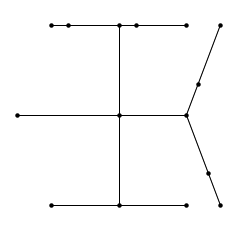

In [13]:

Fig, Axarr = plt.subplots(1,1,figsize=(4,4))
nodes, edges = wntr.graphics.plot_network(wn_leak, ax=Axarr)